In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import numpy as np
import matplotlib.pyplot as plt

In [27]:
(training_genoms, training_labels), (test_genoms, test_labels) = tfds.load("genomics_ood", as_supervised=True, split=["train[0:100000]", "test[0:1000]"], batch_size=(-1))

In [28]:
def onehotify(tensor):
    vocab = {"A":"1", "C":"2", "G":"3", "T":"0"}
    for key in vocab.keys():
      tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot


In [29]:
def build_pipeline(genoms, labels, batch_size, prefetch_size):
    # Transform input to datasets
    genoms_ds = tf.data.Dataset.from_tensor_slices(genoms)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    # preprocess the data
    genoms_ds = genoms_ds.map(onehotify)
    labels_ds = labels_ds.map(lambda x: tf.reshape(tf.one_hot(x, 10), (-1,)))

    # combine the datasets
    ds = tf.data.Dataset.zip((genoms_ds, labels_ds))

    # make batches and shuffle those
    ds = ds.batch(batch_size)
    ds = ds.shuffle(buffer_size=batch_size)
    ds = ds.prefetch(prefetch_size)

    return ds

In [30]:
# Process training and test data
training_ds = build_pipeline(training_genoms, training_labels, 100, 60)
test_ds = build_pipeline(test_genoms, test_labels, 100, 60)

In [31]:
# taken from Tensorflow_Intro.ipynb
class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    @tf.function
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

In [32]:
# taken from Tensorflow_Intro.ipynb
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
      prediction = model(input)
      loss = loss_function(target, prediction)
      gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
      prediction = model(input)
      sample_test_loss = loss_function(target, prediction)
      sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
      sample_test_accuracy = np.mean(sample_test_accuracy)
      test_loss_aggregator.append(sample_test_loss.numpy())
      test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [33]:
# most things from Tensorflow_Intro.ipynb
tf.keras.backend.clear_session()

epochs = 10
learning_rate = 0.1


# Initialize NN
model = Model()
# loss
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# optimizer
gradientDescent = tf.keras.optimizers.SGD(learning_rate)

# lists for vizualisation
training_losses = []

test_losses = []
test_accuracies = []

# testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, training_ds, cross_entropy_loss)
training_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(epochs):
    print('Epoch: __ ' + str(epoch))

    training_ds = training_ds.shuffle(buffer_size=100)
    test_ds = test_ds.shuffle(buffer_size=100)

    #training (and checking in with training)
    for (input,target) in training_ds:
      train_loss = train_step(model, input, target, cross_entropy_loss, gradientDescent)
    training_losses.append(train_loss)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


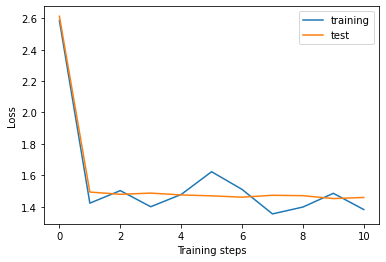

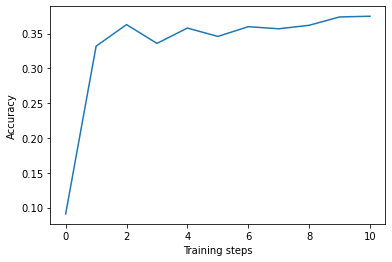

In [34]:
# taken from Tensorflow_Intro.ipynb

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
